In [1]:
# https://www.kaggle.com/code/ryanholbrook/seasonality

## What is Seasonality?

We say that a time series exhibits **seasonality** whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

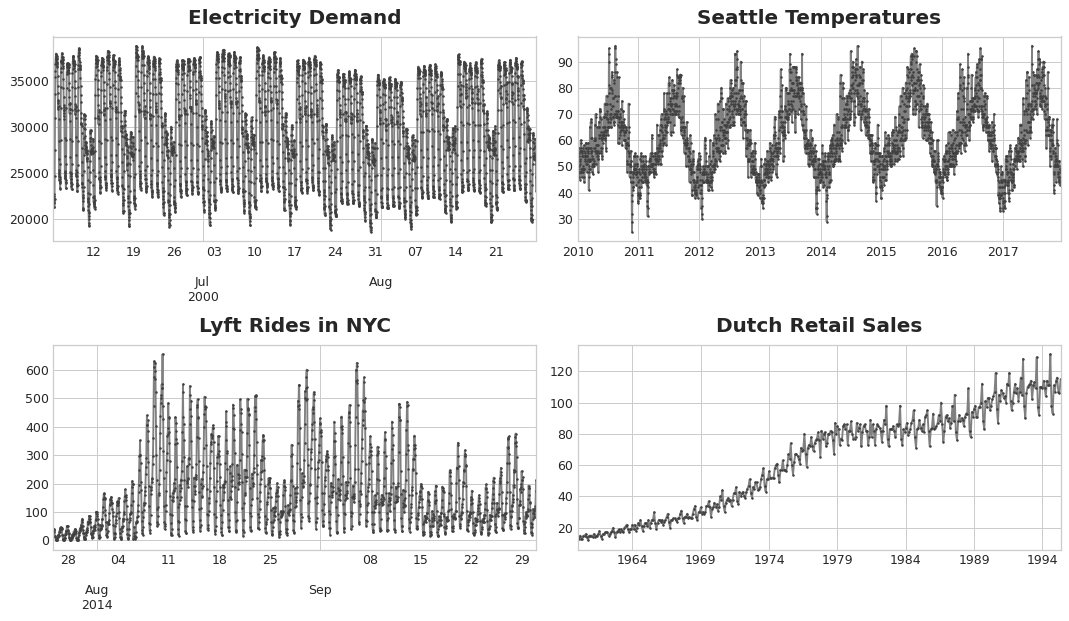

*Seasonal patterns in four time series.*

We will learn two kinds of features that model seasonality. The first kind, indicators, is best for a season with few observations, like a weeekly season of daily observations, like a weekly season of daily observations. The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.

## Seasonal Plots and Seasonal Indicators

Just like we used a moving average plot to discover the trend in a series, we can use a **seasonal plot** to discover seasonal patterns.

A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe. The figure shows a seasonal plot of the daily views of Wikipedia's article on *Trigonometry*: the article's daily views plotted over a common *weekly* period.

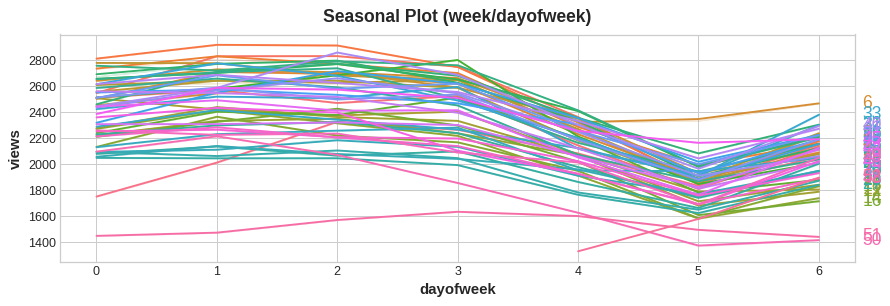

*There is a clear weekly seasonal pattern in this series, higher on weekdays and falling towards the weekend.*

## Seasonal indicators

**Seasonal indicators** are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.

By one-hot encoding days of the week, we get weekly seasonal indicators. Creating weekly indicators for the *Trigonometry* series will then give us six new "dummy" features. (Linear regression works best if you drop one of the indicators; we chose Monday in the frame below.)

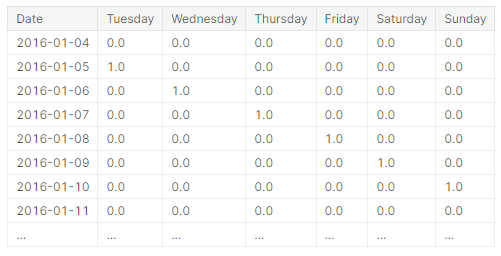

Adding seasonal indicators to the training data helps models distinguish means within a seasonal period:

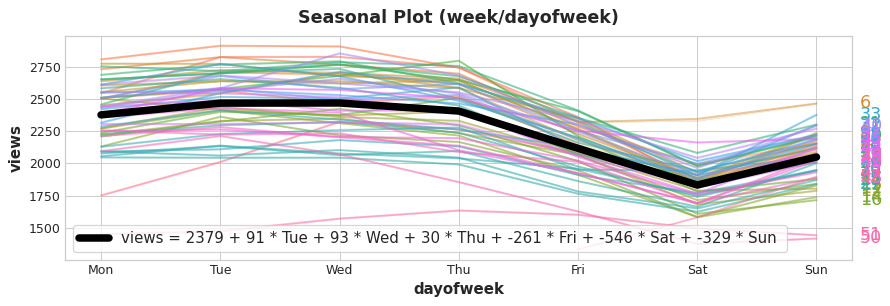

*Ordinary linear regression learns the mean values at each time in the season.*

The indeicators act as On / Off switches. At any time, at most one of these indicators can have a value of [1] *(On)*. Linear regression learns a baseline value [2379] for [Mon] and then adjusts by the value of whichever indicator is [On] for that day; the rest are [0] and vanish.

## Fourier Features and the Periodogram

The kind of feature we discuss now are better suited for long seasons over mnay observations where indicators would be impractical. Instead of creating a feautre of each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features.

Let's take a look at a plot of the annual season in *Trigonometry*. Notice the repetitions of various frequencies: a long up-and-down movement three times a year, short weekly movements 52 times a year, and perhaps others.

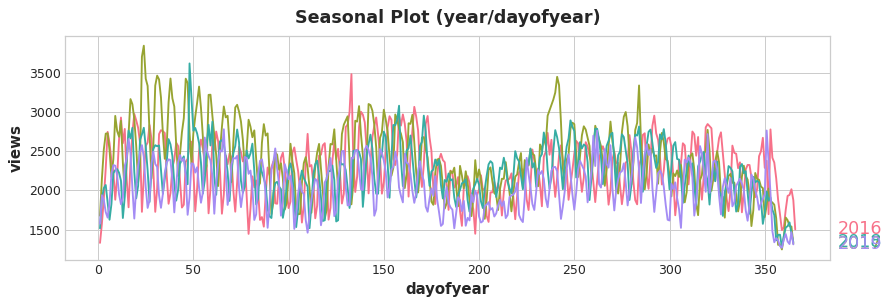

*Annual seasonality in the Wiki Trignometry series*

Its these frequencies within a season that we attempt to capture with Fourier features. The idea is to include in our training data periodic curves having the same frequencies as the season we are trying to model. The curves we use are those in the trigonometric functions sine and cosine.

**Fourier features** are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

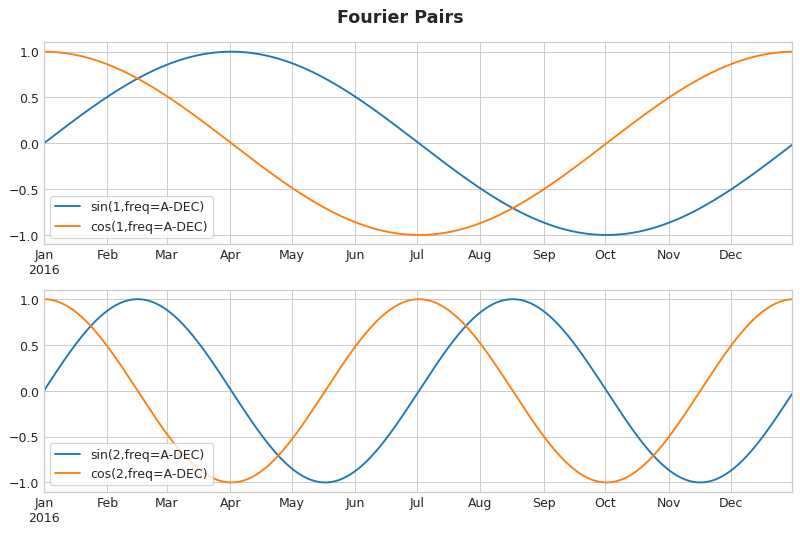

*The first two Fourier pairs for annual seasonality. Top: Frequency of once per year. Bottom: Frequency of twice per year.*

If we add a set of these sine / cosine curves to our training data, the linear regression algorithm will figure out the weights that will fit the seasonal component in the target series. The figure illustrates how linear regression used four Fourier pairs to model the annual seasonilty in the *Wiki Trigonometry* series.

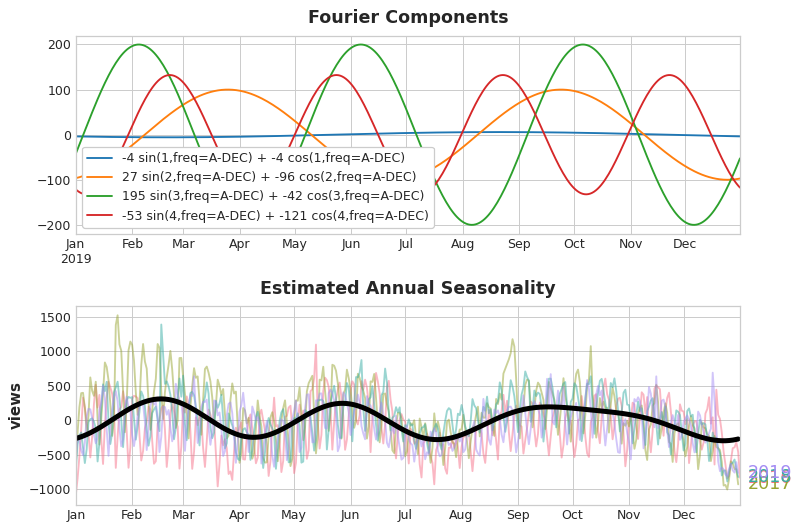

*Top: Curves for four Fourier pairs, a sum of sine and cosine with regression coefficients. Each curve models a different frequency. Bottom: The sum of these curves approximates the seasonal pattern.*

Notice that we only needed eight features (four sine / cosine pairs) to get a good estimate of the annual seasonality. Compare this to the seasonal indicator method which would have required hundreds of features (one for each day of the year). Modeling only the "main effect" of the seasonality with Fourier features, you'll usually  need to add far fewer features to your training data, which means reduced computation time and less risk of overfitting.

## Choosing Fourier features with the Periodogram

how many Fourier pairs should we actuall include in our feature set? We can answer this question with the periodogram. The **periodogram** tells you the strength of the frequencies in a time series. Specifically, the value of the y-axis of the graph is 

Where [a] and [b] are the coefficients of the sine and cosince at that frequency (as in the *Fourier Components* plot above).

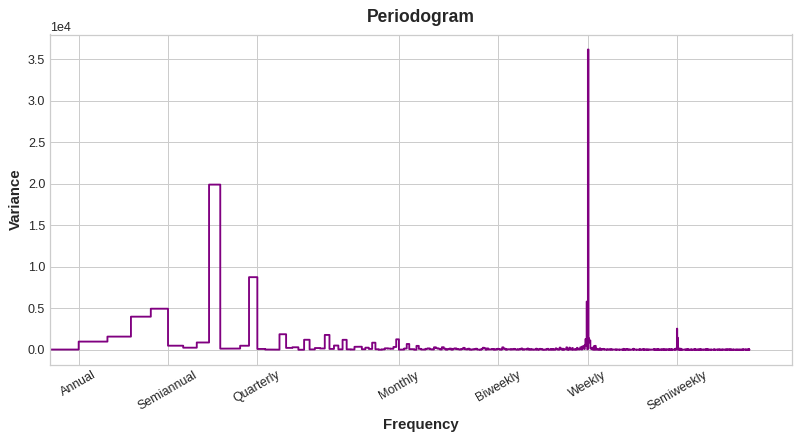

*Periodogram for the Wiki Trigonometry series.*

From left to right, the periodogram drops off after *Quarterly*, four times a year. That was why we chose four Fourier pairs to model the annual season. The *Weekly* frequency we ignore since it's better modeled with indicators.

## Computing Fourier features (optional)

Knowing how Fourier features are computed isn't essential to using them, but if seeing the details would clarify things, the cell hidden cell below illustrates how a set of Fourier features could be derived from the index of a time series. (We'll use a library function from [statsmodels] for our applications, however.)

In [1]:
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)

## Example - Tunnel Traffic

We'll continue once more with the *Tunnel Traffic* dataset. This hidden cell loads the data and defines two functions: [seasonal_plot] and [plot_periodogram].

In [2]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


data_dir = Path("DataSources")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

Let's take a look at seasonal plots over a week and over a year.

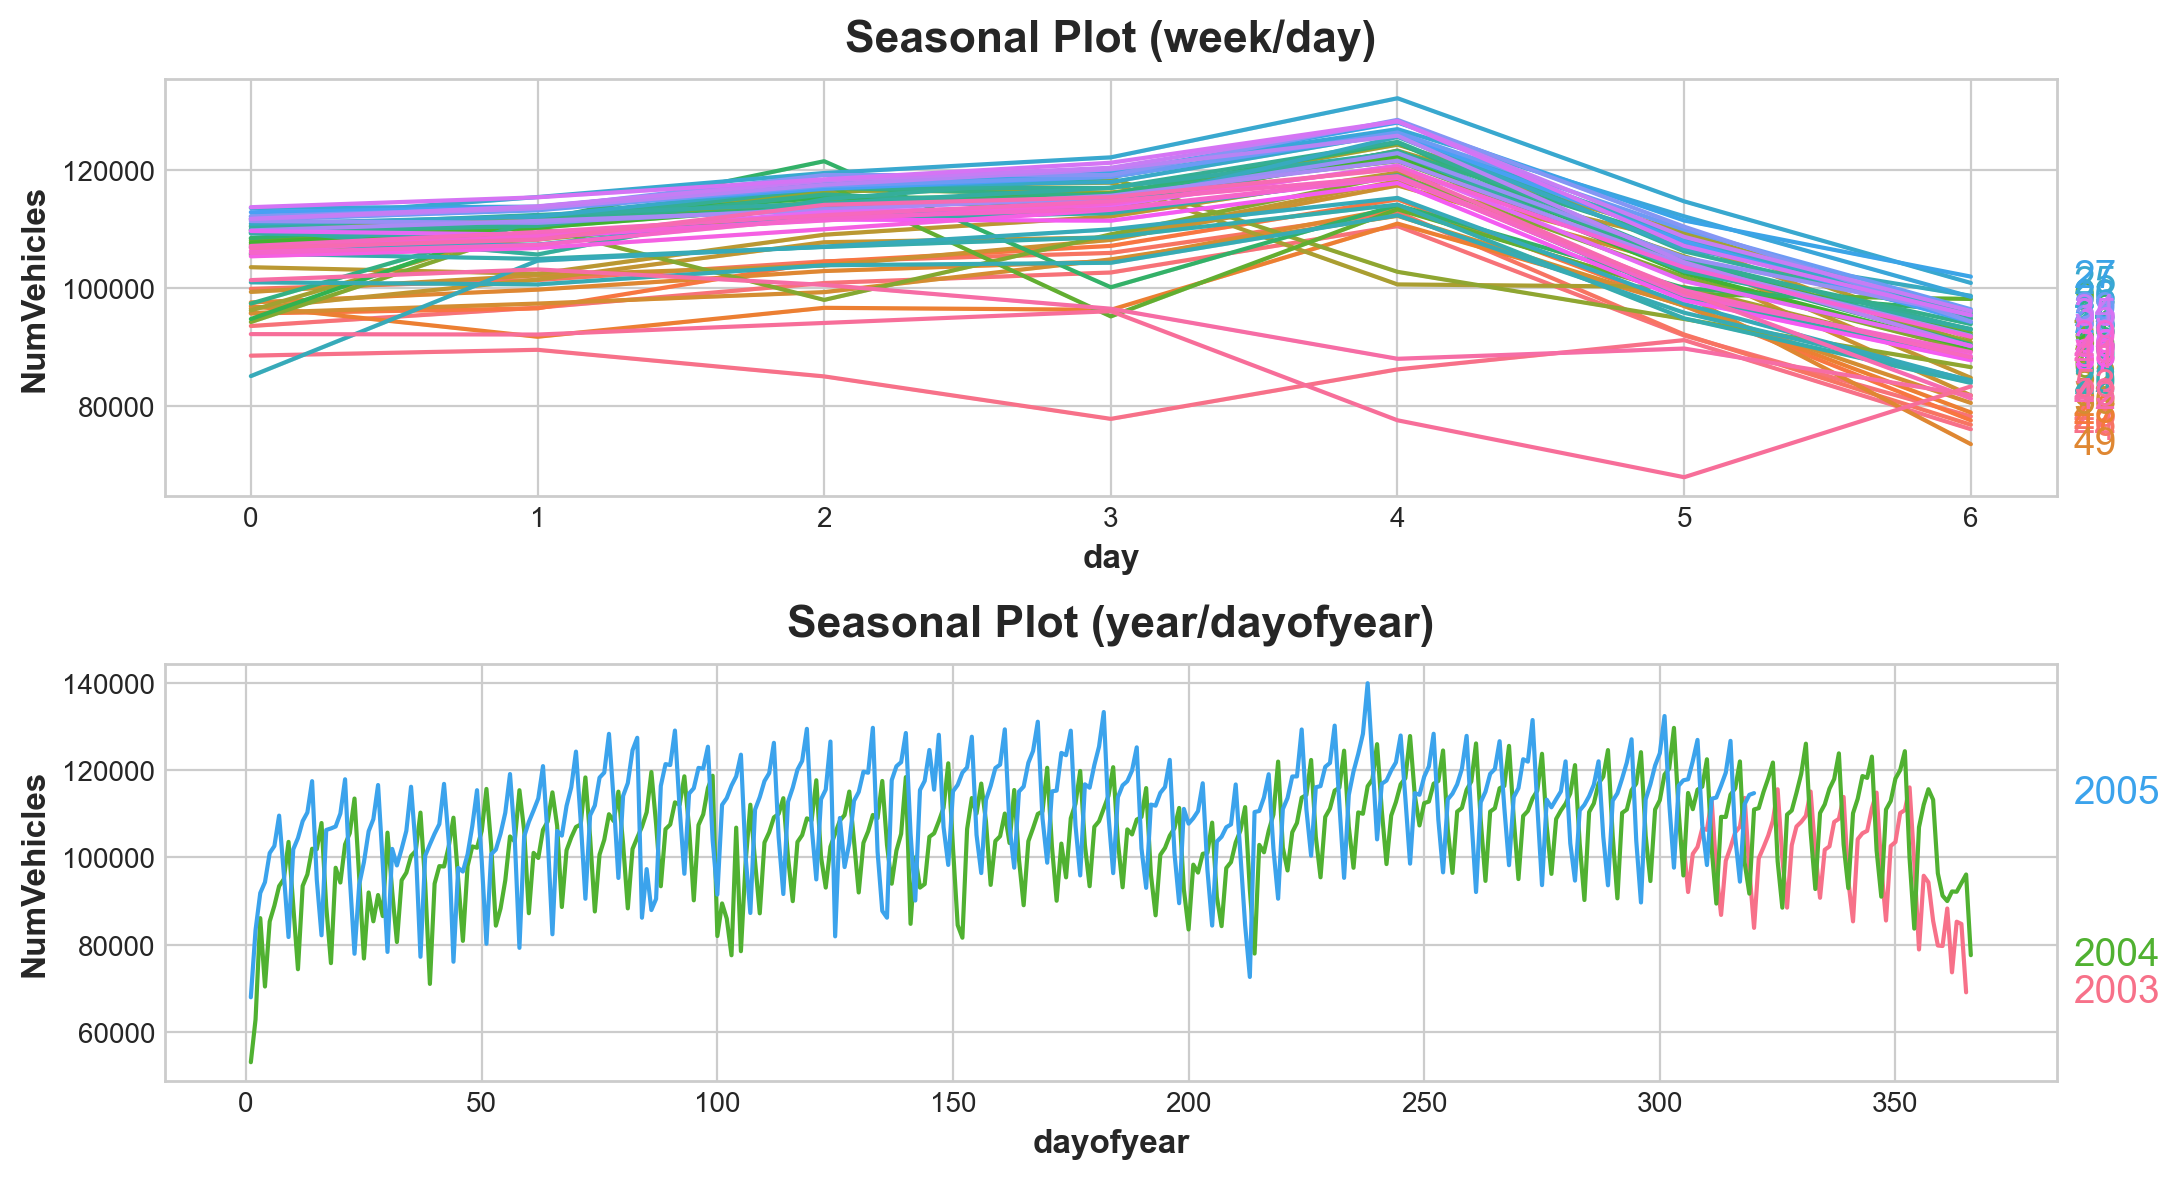

In [3]:
X = tunnel.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

Now let's look at the periodogram:

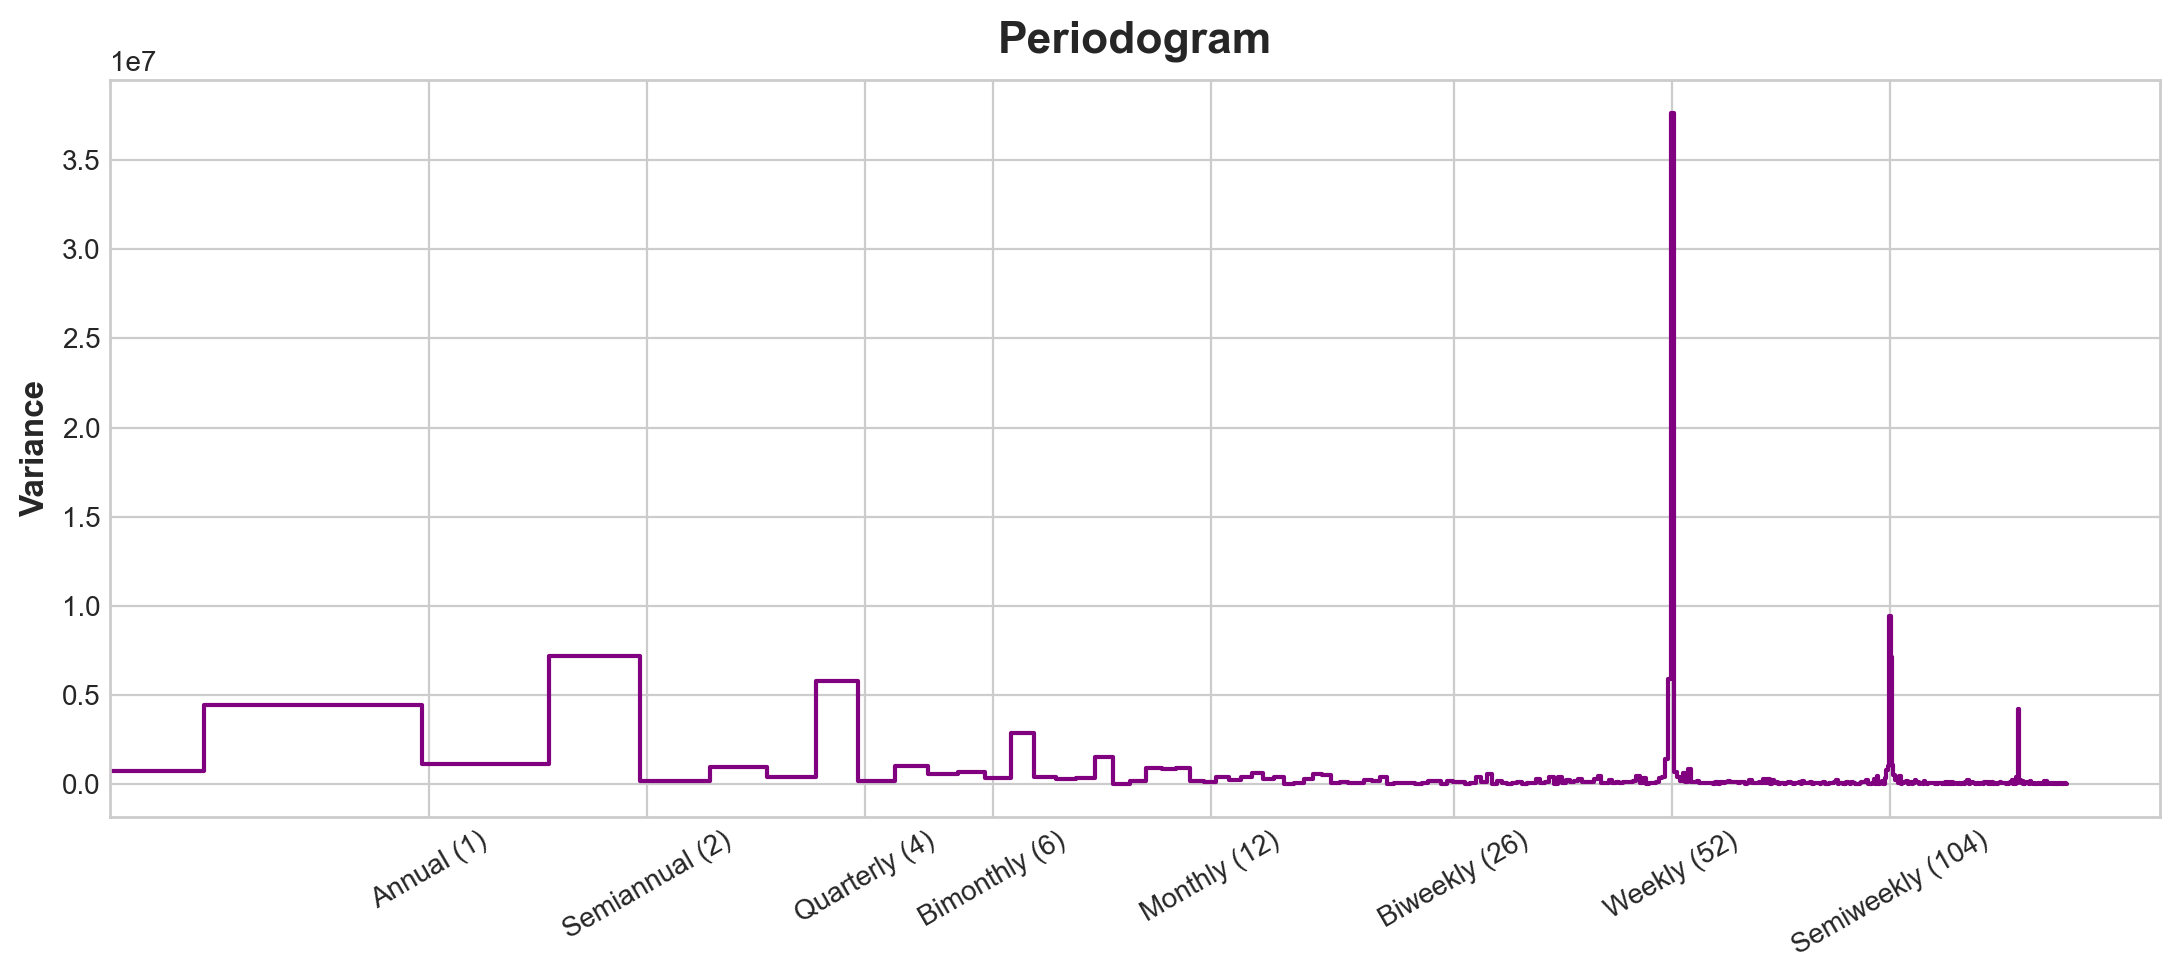

In [4]:
plot_periodogram(tunnel.NumVehicles);